In [1]:
#Prepare Quantum States

import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

def pure_state():
    eps = 1e-7
    rand_ket = qt.rand_ket_haar(4)
    rho_p = qt.ket2dm(qt.Qobj(rand_ket))
    rho_p = (1-eps)*rho_p + (eps/4)*np.eye(4)
    return np.array(rho_p)

def mixed_state(d):
    
    """d = dimension of matrix
    """
    G = np.random.normal(0, 1, [d,d]) + 1j*np.random.normal(0, 1, [d,d])
    G = np.matrix(G)
    rho_m = (G*G.H)/np.trace(G*G.H)
    return rho_m

In [2]:
#Simulate Noise via Variance

def eig_val_corr(state):
    
    """ state = nxn dimensional state
        Corrects state by truncating negative eigenvalues and reconstructs normailized positive
        eigenvalued eigenvectos' states
    """
    if np.sum(np.linalg.eig(state)[0].real < 0) > 0 or np.sum(np.linalg.eig(state)[0].real > 1):
        eig_val, eig_vec = np.linalg.eig(state)
        eig_val = eig_val.real
        eig_val[eig_val < 0] = 0
        eig_val = eig_val/np.sum(eig_val)
        
        d = state.shape[0]
        state = np.zeros([d,d], dtype = 'complex')
        for ij in range(d):
            state += eig_val[ij]*np.matmul(eig_vec[ij].reshape(d,1), np.matrix(eig_vec[ij].reshape(d,1)).H)
            
    return state
            
def noise_state(state, var):
    
    """ state = 4x4 quantum state
        var = scalar value. High var = high noise in state to be measured.
    """
    d = state.shape[0]
    noisy_state_raw = state + np.random.normal(0, var, [d,d]) + 1j*np.random.normal(0, var, [d,d])
    
    if np.sum(np.linalg.eig(noisy_state_raw)[0].real < 0) > 0:
        state = eig_val_corr(noisy_state_raw)
    else:
        state = noisy_state_raw
            
    return state

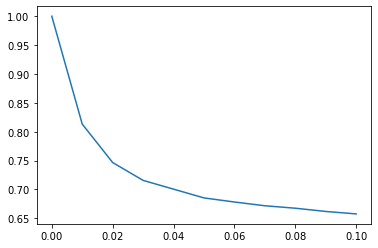

In [3]:
#checking relation between var and infidelity

fid = np.zeros([11, 1000])
k=0
for ij in range(11):
    var = 0.01*ij
    for jk in range(1000):
        rho = mixed_state(d=8)
        rho_noisy = noise_state(rho, var)

        fid[ij, jk] = qt.fidelity(qt.Qobj(rho), qt.Qobj(rho_noisy))
        
plt.plot(0.01*np.arange(11), np.mean(fid, axis=1))

In [4]:
def pauli_basis():
    
    I = np.array([[1, 0],
                  [0, 1]], dtype = 'complex')
    X = np.array([[0, 1],
                  [1, 0]], dtype = 'complex')
    Y = np.array([[0, -1j],
                  [1j, 0]], dtype = 'complex')
    Z = np.array([[1, 0],
                  [0, -1]], dtype = 'complex')
    pauli = np.array([I, X, Y ,Z], dtype = 'complex')
    
    return pauli

def pauli_words(optrs, qbts):
    if qbts == 1:
        return optrs
    else:
        d = optrs.shape[-1]
        pauli = pauli_basis()
        temp_optrs = np.zeros([(2*d)**2, d*2, d*2], dtype = 'complex')
        optrs = optrs.reshape([d**2, d, d])
        for i in range(4):
            for j in range(d**2):
                temp_optrs[(d**2)*i + j] = np.kron(pauli[i], optrs[j])
        rep_4 = int(np.log10((2*d)**2)/np.log10(4))
        temp_optrs = temp_optrs.reshape(np.append(np.repeat(4, rep_4), [d*2, d*2]))
        return pauli_words(temp_optrs, qbts - 1)


def counts_to_bloch(rho_noisy, optrs, shots, qbts):
    
    mn_rnd = np.zeros([4**qbts, 2**qbts])
    mn_eval = np.zeros([4**qbts, 2**qbts])

    for ii in range(4**qbts):
        rr = np.zeros([1, 2**qbts])
        for jj in range(2**qbts):
            e_val, e_vec = np.linalg.eig(optrs.reshape(64, 8, 8)[ii])
            e_vec = np.matrix(e_vec[:,jj]).transpose()
            e_vec_mat = e_vec*e_vec.getH()
            rr[0, jj] = np.real(np.trace(np.matmul(rho_noisy, e_vec_mat)))
        rr = np.round(rr[0], 8)
        rr[rr < 0] = 0
        rr = rr/np.sum(rr)
        rr[-1] = 1 - np.sum(rr[:-1])
        if np.sum(rr < 0) > 0:
            print(rr)
        rr[rr < 0.0000000001] = 0
        mn_rnd[ii, :] = np.random.multinomial(shots, rr)
        mn_eval[ii, :] = e_val.real

    return np.sum(mn_rnd*mn_eval, axis=1)/shots

In [5]:
data_pts = 10000
d = 8
var_vals = 5
k = np.zeros(64)
qbts = 3
shots = 1000

optrs = pauli_words(pauli_basis(), qbts)

var_0_L = np.zeros([data_pts, 64])
var_0_I = np.zeros([data_pts, 64])
v0 = 0

var_1_L = np.zeros([data_pts, 64])
var_1_I = np.zeros([data_pts, 64])
v1 = 0

var_2_L = np.zeros([data_pts, 64])
var_2_I = np.zeros([data_pts, 64])
v2 = 0

var_3_L = np.zeros([data_pts, 64])
var_3_I = np.zeros([data_pts, 64])
v3 = 0

var_4_L = np.zeros([data_pts, 64])
var_4_I = np.zeros([data_pts, 64])
v4 = 0

for ij in range(data_pts):
    
    rho = mixed_state(d)
    
    for jk in range(var_vals):
        var = 0.01*jk
        rho_noisy = noise_state(rho, var)
        
        temp_labels = np.zeros([4,4,4])
        temp_inputs = np.zeros([4,4,4])
        
        for i in range(4):
            for j in range(4):
                for k in range(4):
                    temp_labels[i, j, k] = np.trace(np.matmul(optrs[i,j,k], rho))        
         
        if jk == 0:
            var_0_L[v0] = temp_labels.reshape(64)
            var_0_I[v0] = counts_to_bloch(rho_noisy,optrs, shots, qbts)
            v0 += 1
        
        if jk == 1:
            var_1_L[v1] = temp_labels.reshape(64)
            var_1_I[v1] = counts_to_bloch(rho_noisy,optrs, shots, qbts)
            v1 += 1
            
        if jk == 2:
            var_2_L[v2] = temp_labels.reshape(64)
            var_2_I[v2] = counts_to_bloch(rho_noisy,optrs, shots, qbts)
            v2 += 1
        
        if jk == 3:
            var_3_L[v3] = temp_labels.reshape(64)
            var_3_I[v3] = counts_to_bloch(rho_noisy,optrs, shots, qbts)
            v3 += 1
            
        if jk == 4:
            var_4_L[v4] = temp_labels.reshape(64)
            var_4_I[v4] = counts_to_bloch(rho_noisy,optrs, shots, qbts)
            v4 += 1
    if ij%100 == 0:
        print("Datapoint:",ij)

<ipython-input-5-c81be5ade337>:44: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_labels[i, j, k] = np.trace(np.matmul(optrs[i,j,k], rho))


Datapoint: 0
Datapoint: 100
Datapoint: 200
Datapoint: 300
Datapoint: 400
Datapoint: 500
Datapoint: 600
Datapoint: 700
Datapoint: 800
Datapoint: 900
Datapoint: 1000
Datapoint: 1100
Datapoint: 1200
Datapoint: 1300
Datapoint: 1400
Datapoint: 1500
Datapoint: 1600
Datapoint: 1700
Datapoint: 1800
Datapoint: 1900
Datapoint: 2000
Datapoint: 2100
Datapoint: 2200
Datapoint: 2300
Datapoint: 2400
Datapoint: 2500
Datapoint: 2600
Datapoint: 2700
Datapoint: 2800
Datapoint: 2900
Datapoint: 3000
Datapoint: 3100
Datapoint: 3200
Datapoint: 3300
Datapoint: 3400
Datapoint: 3500
Datapoint: 3600
Datapoint: 3700
Datapoint: 3800
Datapoint: 3900
Datapoint: 4000
Datapoint: 4100
Datapoint: 4200
Datapoint: 4300
Datapoint: 4400
Datapoint: 4500
Datapoint: 4600
Datapoint: 4700
Datapoint: 4800
Datapoint: 4900
Datapoint: 5000
Datapoint: 5100
Datapoint: 5200
Datapoint: 5300
Datapoint: 5400
Datapoint: 5500
Datapoint: 5600
Datapoint: 5700
[ 1.13393531e-01  1.19088996e-01  2.30316358e-01  1.58550668e-01
  1.30238959e-01  1

In [10]:
def state_recon_bloch_vec(optrs, r):
    
    """return state given pauli tensors of X, Y, Z and bloch vectors of size d**qbts
    """
    var_0_L_a = r.reshape(4,4,4)
    state_act = np.zeros([8,8], dtype = 'complex')

    for i in range(4):
        for j in range(4):
            for k in range(4):
                state_act += var_0_L_a[i, j, k]*optrs[i,j,k]
    
    return state_act/8
                
state_act = state_recon_bloch_vec(optrs, var_4_L[2])
state_est = state_recon_bloch_vec(optrs, var_4_I[2])
            
qt.fidelity(qt.Qobj(state_act), qt.Qobj(state_est))

def fid_avg(r_noise, r_actual, l):
    
    fidelity = 0.0
    for ij in range(l):
        a = state_recon_bloch_vec(optrs, r_noise[ij])
        b = state_recon_bloch_vec(optrs, r_actual[ij])
        fidelity += qt.fidelity(qt.Qobj(a), qt.Qobj(b))
    return fidelity/l

def mse(x1, y1):
    
    MSE = np.square(np.subtract(x1,y1)).mean()
    return MSE

def mse_avg(X, Y):
    
    x_len = X.shape[0]
    y_len = Y.shape[0]
    
    avg_mse = 0.0
    
    if x_len == y_len:
        for ii in range(x_len):
            avg_mse += mse(X[ii], Y[ii])
    
    return avg_mse/x_len

a_f = fid_avg(var_0_I, var_0_L, data_pts)
a_m = mse_avg(var_0_I, var_0_L)

b_f = fid_avg(var_1_I, var_1_L, data_pts)
b_m = mse_avg(var_1_I, var_1_L)

c_f = fid_avg(var_2_I, var_2_L, data_pts)
c_m = mse_avg(var_2_I, var_2_L)

d_f = fid_avg(var_3_I, var_3_L, data_pts)
d_m = mse_avg(var_3_I, var_3_L)

e_f = fid_avg(var_4_I, var_4_L, data_pts)
e_m = mse_avg(var_4_I, var_4_L)

print(a_f, b_f, c_f, d_f, e_f)
print(a_m, b_m, c_m, d_m, e_m)

0.9912356387433503 0.805200699096597 0.7395621299442228 0.7147399115680038 0.7018975208374534
0.0009700103463936643 0.025321809009177923 0.03520112095728505 0.03937028087760285 0.04150426725347966


#N = 10


#N = 100  
0.9658720252728576 0.8033813290499711 0.7483017731774276 0.7178030796983127 0.7117393802535091 -> 1000 copies   
0.9659714884673475 0.795450178700517 0.7444010676587345 0.7205603263362355 0.7130375925974438 -> 10,000 copies

#N = 1000   -> 10,000 copies    
Infidelity: 0.9912356387433503 0.805200699096597 0.7395621299442228 0.7147399115680038 0.7018975208374534      
MSE: 0.0009700103463936643 0.025321809009177923 0.03520112095728505 0.03937028087760285 0.04150426725347966

#N = 10000


In [11]:
import torch

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [62]:
#create datasets
#200 DMs for pure and mixed each
#perform 200 noisy meaurements on each with var=pi/6

M_dataset = var_0_I #1000x64
M_label = var_0_L #1000x64

In [63]:
M_ds = M_dataset.reshape(data_pts,1, 8, 8).real
M_l = M_label.reshape(data_pts, 64).real

In [64]:
ds_len = data_pts
test_size = 0.1
indices = list(range(ds_len))
np.random.shuffle(indices)
split = int(np.floor(test_size * ds_len))
train_idx, test_idx = indices[split:], indices[:split]

M_testset = M_ds[test_idx]
M_testlabel = M_l[test_idx]
M_trainset = M_ds[train_idx]
M_trainlabel = M_l[train_idx]

train_len = int(ds_len*(1-test_size))
valid_size = 0.2
indices = list(range(train_len))
np.random.shuffle(indices)
split = int(np.floor(valid_size * train_len))
train_idx, valid_idx = indices[split:], indices[:split]

M_validset = M_trainset[valid_idx]
M_validlabel = M_trainlabel[valid_idx]
M_trainset = M_trainset[train_idx]
M_trainlabel = M_trainlabel[train_idx]

In [65]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 50

#mixed_train_set
M_trainset = torch.Tensor(M_trainset) # transform to torch tensor
M_trainlabel = torch.tensor(M_trainlabel)

#mixed_valid set
M_validset = torch.Tensor(M_validset) # transform to torch tensor
M_validlabel = torch.tensor(M_validlabel)

#mixed_test set
M_testset = torch.Tensor(M_testset) # transform to torch tensor
M_testlabel = torch.tensor(M_testlabel)

#datasets
train_data = TensorDataset(M_trainset, M_trainlabel)
valid_data = TensorDataset(M_validset, M_validlabel)
test_data = TensorDataset(M_testset, M_testlabel)

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size)
valid_loader = DataLoader(valid_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [39]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 8x8x1 image tensor)
        self.conv1 = nn.Conv2d(1, 24, 3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(24)
        self.dropout1 = nn.Dropout2d(0.25)
#         convolutional layer (sees 4x4x12 tensor)
        self.conv2 = nn.Conv2d(24, 128, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(128)
        
#         # convolutional layer (sees 2x2x64 tensor)
#         self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
#         self.conv3_bn = nn.BatchNorm2d(128)

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (128 * 2 * 2 -> 450)
        self.fc1 = nn.Linear(2048, 256)
        # linear layer (256 -> 64)
        self.fc2 = nn.Linear(256, 64)
        # dropout layer (p=0.5)
        self.dropout = nn.Dropout(0.10)
        self.m = nn.ELU()
        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = F.relu(self.conv1(x))
        x = self.conv1_bn(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = F.relu(self.conv2(x))
        x = self.conv2_bn(x)
#         x = self.pool(x)
#         x = F.relu(self.conv3(x))
#         x = self.conv3_bn(x)

        # flatten input
        x = x.view(-1, 2048)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = self.m(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.m(self.fc2(x))
        return x

In [40]:
import torch.optim as optim

model = Net()

# specify loss function (categorical cross-entropy)
criterion = nn.MSELoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)
# optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [41]:
# create a complete CNN
# trained pn v1

print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

# number of epochs to train the model
n_epochs = 1000
# model = model.float()
valid_loss_min = np.Inf # track change in validation loss

train_losses, valid_losses = [], []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            data, target = data.float(), target.float()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    # At completion of epoch
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'NN_QST_1_KICS_21.pt')
        valid_loss_min = valid_loss

Net(
  (conv1): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(24, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (m): ELU(alpha=1.0)
)
Epoch: 1 	Training Loss: 0.067348 	Validation Loss: 0.033790
Validation loss decreased (inf --> 0.033790).  Saving model ...
Epoch: 2 	Training Loss: 0.052150 	Validation Loss: 0.028719
Validation loss decreased (0.033790 --> 0.028719).  Saving model ...
Epoch: 3 	Training Loss: 0.045881 	Validation Loss: 0.025776
Validation lo

Epoch: 59 	Training Loss: 0.022192 	Validation Loss: 0.015846
Validation loss decreased (0.015870 --> 0.015846).  Saving model ...
Epoch: 60 	Training Loss: 0.022155 	Validation Loss: 0.015835
Validation loss decreased (0.015846 --> 0.015835).  Saving model ...
Epoch: 61 	Training Loss: 0.022105 	Validation Loss: 0.015817
Validation loss decreased (0.015835 --> 0.015817).  Saving model ...
Epoch: 62 	Training Loss: 0.022051 	Validation Loss: 0.015799
Validation loss decreased (0.015817 --> 0.015799).  Saving model ...
Epoch: 63 	Training Loss: 0.021922 	Validation Loss: 0.015771
Validation loss decreased (0.015799 --> 0.015771).  Saving model ...
Epoch: 64 	Training Loss: 0.021814 	Validation Loss: 0.015758
Validation loss decreased (0.015771 --> 0.015758).  Saving model ...
Epoch: 65 	Training Loss: 0.021743 	Validation Loss: 0.015743
Validation loss decreased (0.015758 --> 0.015743).  Saving model ...
Epoch: 66 	Training Loss: 0.021608 	Validation Loss: 0.015740
Validation loss decre

Epoch: 131 	Training Loss: 0.018363 	Validation Loss: 0.015162
Validation loss decreased (0.015166 --> 0.015162).  Saving model ...
Epoch: 132 	Training Loss: 0.018359 	Validation Loss: 0.015170
Epoch: 133 	Training Loss: 0.018327 	Validation Loss: 0.015155
Validation loss decreased (0.015162 --> 0.015155).  Saving model ...
Epoch: 134 	Training Loss: 0.018302 	Validation Loss: 0.015146
Validation loss decreased (0.015155 --> 0.015146).  Saving model ...
Epoch: 135 	Training Loss: 0.018290 	Validation Loss: 0.015142
Validation loss decreased (0.015146 --> 0.015142).  Saving model ...
Epoch: 136 	Training Loss: 0.018290 	Validation Loss: 0.015139
Validation loss decreased (0.015142 --> 0.015139).  Saving model ...
Epoch: 137 	Training Loss: 0.018248 	Validation Loss: 0.015132
Validation loss decreased (0.015139 --> 0.015132).  Saving model ...
Epoch: 138 	Training Loss: 0.018214 	Validation Loss: 0.015133
Epoch: 139 	Training Loss: 0.018168 	Validation Loss: 0.015122
Validation loss dec

Epoch: 214 	Training Loss: 0.016931 	Validation Loss: 0.014934
Validation loss decreased (0.014937 --> 0.014934).  Saving model ...
Epoch: 215 	Training Loss: 0.016882 	Validation Loss: 0.014933
Validation loss decreased (0.014934 --> 0.014933).  Saving model ...
Epoch: 216 	Training Loss: 0.016910 	Validation Loss: 0.014943
Epoch: 217 	Training Loss: 0.016896 	Validation Loss: 0.014937
Epoch: 218 	Training Loss: 0.016871 	Validation Loss: 0.014932
Validation loss decreased (0.014933 --> 0.014932).  Saving model ...
Epoch: 219 	Training Loss: 0.016868 	Validation Loss: 0.014925
Validation loss decreased (0.014932 --> 0.014925).  Saving model ...
Epoch: 220 	Training Loss: 0.016855 	Validation Loss: 0.014933
Epoch: 221 	Training Loss: 0.016837 	Validation Loss: 0.014926
Epoch: 222 	Training Loss: 0.016823 	Validation Loss: 0.014928
Epoch: 223 	Training Loss: 0.016822 	Validation Loss: 0.014928
Epoch: 224 	Training Loss: 0.016853 	Validation Loss: 0.014925
Validation loss decreased (0.01

Epoch: 308 	Training Loss: 0.016275 	Validation Loss: 0.014830
Validation loss decreased (0.014832 --> 0.014830).  Saving model ...
Epoch: 309 	Training Loss: 0.016230 	Validation Loss: 0.014834
Epoch: 310 	Training Loss: 0.016238 	Validation Loss: 0.014842
Epoch: 311 	Training Loss: 0.016234 	Validation Loss: 0.014843
Epoch: 312 	Training Loss: 0.016203 	Validation Loss: 0.014841
Epoch: 313 	Training Loss: 0.016228 	Validation Loss: 0.014837
Epoch: 314 	Training Loss: 0.016206 	Validation Loss: 0.014840
Epoch: 315 	Training Loss: 0.016169 	Validation Loss: 0.014833
Epoch: 316 	Training Loss: 0.016195 	Validation Loss: 0.014836
Epoch: 317 	Training Loss: 0.016202 	Validation Loss: 0.014835
Epoch: 318 	Training Loss: 0.016206 	Validation Loss: 0.014825
Validation loss decreased (0.014830 --> 0.014825).  Saving model ...
Epoch: 319 	Training Loss: 0.016213 	Validation Loss: 0.014833
Epoch: 320 	Training Loss: 0.016198 	Validation Loss: 0.014836
Epoch: 321 	Training Loss: 0.016186 	Valida

Epoch: 413 	Training Loss: 0.015843 	Validation Loss: 0.014780
Epoch: 414 	Training Loss: 0.015849 	Validation Loss: 0.014778
Validation loss decreased (0.014779 --> 0.014778).  Saving model ...
Epoch: 415 	Training Loss: 0.015834 	Validation Loss: 0.014786
Epoch: 416 	Training Loss: 0.015836 	Validation Loss: 0.014777
Validation loss decreased (0.014778 --> 0.014777).  Saving model ...
Epoch: 417 	Training Loss: 0.015849 	Validation Loss: 0.014780
Epoch: 418 	Training Loss: 0.015842 	Validation Loss: 0.014775
Validation loss decreased (0.014777 --> 0.014775).  Saving model ...
Epoch: 419 	Training Loss: 0.015820 	Validation Loss: 0.014774
Validation loss decreased (0.014775 --> 0.014774).  Saving model ...
Epoch: 420 	Training Loss: 0.015843 	Validation Loss: 0.014786
Epoch: 421 	Training Loss: 0.015817 	Validation Loss: 0.014780
Epoch: 422 	Training Loss: 0.015810 	Validation Loss: 0.014776
Epoch: 423 	Training Loss: 0.015795 	Validation Loss: 0.014780
Epoch: 424 	Training Loss: 0.01

Epoch: 521 	Training Loss: 0.015622 	Validation Loss: 0.014748
Epoch: 522 	Training Loss: 0.015610 	Validation Loss: 0.014744
Epoch: 523 	Training Loss: 0.015619 	Validation Loss: 0.014739
Validation loss decreased (0.014743 --> 0.014739).  Saving model ...
Epoch: 524 	Training Loss: 0.015606 	Validation Loss: 0.014747
Epoch: 525 	Training Loss: 0.015565 	Validation Loss: 0.014741
Epoch: 526 	Training Loss: 0.015590 	Validation Loss: 0.014738
Validation loss decreased (0.014739 --> 0.014738).  Saving model ...
Epoch: 527 	Training Loss: 0.015607 	Validation Loss: 0.014742
Epoch: 528 	Training Loss: 0.015607 	Validation Loss: 0.014736
Validation loss decreased (0.014738 --> 0.014736).  Saving model ...
Epoch: 529 	Training Loss: 0.015578 	Validation Loss: 0.014743
Epoch: 530 	Training Loss: 0.015619 	Validation Loss: 0.014742
Epoch: 531 	Training Loss: 0.015588 	Validation Loss: 0.014745
Epoch: 532 	Training Loss: 0.015595 	Validation Loss: 0.014745
Epoch: 533 	Training Loss: 0.015592 	

Epoch: 637 	Training Loss: 0.015406 	Validation Loss: 0.014715
Epoch: 638 	Training Loss: 0.015424 	Validation Loss: 0.014716
Epoch: 639 	Training Loss: 0.015425 	Validation Loss: 0.014720
Epoch: 640 	Training Loss: 0.015409 	Validation Loss: 0.014706
Validation loss decreased (0.014710 --> 0.014706).  Saving model ...
Epoch: 641 	Training Loss: 0.015404 	Validation Loss: 0.014718
Epoch: 642 	Training Loss: 0.015419 	Validation Loss: 0.014713
Epoch: 643 	Training Loss: 0.015402 	Validation Loss: 0.014712
Epoch: 644 	Training Loss: 0.015411 	Validation Loss: 0.014716
Epoch: 645 	Training Loss: 0.015422 	Validation Loss: 0.014719
Epoch: 646 	Training Loss: 0.015424 	Validation Loss: 0.014708
Epoch: 647 	Training Loss: 0.015389 	Validation Loss: 0.014715
Epoch: 648 	Training Loss: 0.015402 	Validation Loss: 0.014718
Epoch: 649 	Training Loss: 0.015411 	Validation Loss: 0.014710
Epoch: 650 	Training Loss: 0.015419 	Validation Loss: 0.014714
Epoch: 651 	Training Loss: 0.015412 	Validation L

Epoch: 754 	Training Loss: 0.015293 	Validation Loss: 0.014695
Epoch: 755 	Training Loss: 0.015280 	Validation Loss: 0.014695
Epoch: 756 	Training Loss: 0.015308 	Validation Loss: 0.014691
Epoch: 757 	Training Loss: 0.015267 	Validation Loss: 0.014691
Epoch: 758 	Training Loss: 0.015293 	Validation Loss: 0.014696
Epoch: 759 	Training Loss: 0.015275 	Validation Loss: 0.014694
Epoch: 760 	Training Loss: 0.015285 	Validation Loss: 0.014688
Epoch: 761 	Training Loss: 0.015286 	Validation Loss: 0.014695
Epoch: 762 	Training Loss: 0.015285 	Validation Loss: 0.014692
Epoch: 763 	Training Loss: 0.015274 	Validation Loss: 0.014688
Epoch: 764 	Training Loss: 0.015287 	Validation Loss: 0.014693
Epoch: 765 	Training Loss: 0.015271 	Validation Loss: 0.014697
Epoch: 766 	Training Loss: 0.015281 	Validation Loss: 0.014694
Epoch: 767 	Training Loss: 0.015267 	Validation Loss: 0.014694
Epoch: 768 	Training Loss: 0.015290 	Validation Loss: 0.014695
Epoch: 769 	Training Loss: 0.015287 	Validation Loss: 0

Epoch: 872 	Training Loss: 0.015189 	Validation Loss: 0.014674
Epoch: 873 	Training Loss: 0.015183 	Validation Loss: 0.014680
Epoch: 874 	Training Loss: 0.015182 	Validation Loss: 0.014671
Epoch: 875 	Training Loss: 0.015176 	Validation Loss: 0.014674
Epoch: 876 	Training Loss: 0.015190 	Validation Loss: 0.014663
Validation loss decreased (0.014667 --> 0.014663).  Saving model ...
Epoch: 877 	Training Loss: 0.015163 	Validation Loss: 0.014665
Epoch: 878 	Training Loss: 0.015163 	Validation Loss: 0.014674
Epoch: 879 	Training Loss: 0.015190 	Validation Loss: 0.014673
Epoch: 880 	Training Loss: 0.015176 	Validation Loss: 0.014673
Epoch: 881 	Training Loss: 0.015158 	Validation Loss: 0.014670
Epoch: 882 	Training Loss: 0.015159 	Validation Loss: 0.014674
Epoch: 883 	Training Loss: 0.015168 	Validation Loss: 0.014671
Epoch: 884 	Training Loss: 0.015160 	Validation Loss: 0.014672
Epoch: 885 	Training Loss: 0.015181 	Validation Loss: 0.014678
Epoch: 886 	Training Loss: 0.015183 	Validation L

Epoch: 990 	Training Loss: 0.015094 	Validation Loss: 0.014650
Validation loss decreased (0.014651 --> 0.014650).  Saving model ...
Epoch: 991 	Training Loss: 0.015087 	Validation Loss: 0.014650
Epoch: 992 	Training Loss: 0.015082 	Validation Loss: 0.014660
Epoch: 993 	Training Loss: 0.015092 	Validation Loss: 0.014657
Epoch: 994 	Training Loss: 0.015096 	Validation Loss: 0.014654
Epoch: 995 	Training Loss: 0.015090 	Validation Loss: 0.014649
Validation loss decreased (0.014650 --> 0.014649).  Saving model ...
Epoch: 996 	Training Loss: 0.015094 	Validation Loss: 0.014652
Epoch: 997 	Training Loss: 0.015077 	Validation Loss: 0.014653
Epoch: 998 	Training Loss: 0.015079 	Validation Loss: 0.014650
Epoch: 999 	Training Loss: 0.015092 	Validation Loss: 0.014656
Epoch: 1000 	Training Loss: 0.015077 	Validation Loss: 0.014650


Text(0.5, 1.0, 'V2')

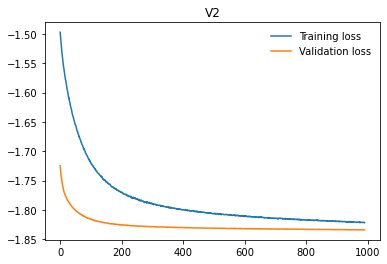

In [42]:
plt.plot(np.log10(train_losses[10:2000]), label='Training loss')
plt.plot(np.log10(valid_losses[10:2000]), label='Validation loss')
plt.legend(frameon=False)
plt.title('V2')

In [43]:
# model.load_state_dict(torch.load('NN_QST_2_KICS_20.pt'))
# model.load_state_dict(torch.load('NN_QST_2_KICS_21.pt'))
model.load_state_dict(torch.load('NN_QST_1_KICS_21.pt'))
# model.load_state_dict(torch.load('NN_QST_2_KICS_23.pt'))
# model.load_state_dict(torch.load('NN_QST_2_KICS_24.pt'))

<All keys matched successfully>

In [44]:
# track test loss on v1
test_loss = 0.0
fidelity = 0.0
if train_on_gpu:
    model.cuda()
model.eval()
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        with torch.no_grad():
            data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            for ij in range(batch_size):
                aa = np.array(output.cpu().numpy()[ij])
                bb = np.array(target.cpu().numpy()[ij])
                rho1 = state_recon_bloch_vec(optrs, aa)
                rho2 = state_recon_bloch_vec(optrs, bb)
                rho1 = eig_val_corr(rho1)
                rho2 = eig_val_corr(rho2)
                fidelity += qt.fidelity(qt.Qobj(rho1), qt.Qobj(rho2))
                
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            test_loss += loss.item()*data.size(0)
    print('Loss per Batch: {:.6f}'.format(loss))
    
# calculate average losses
test_loss = test_loss/len(test_loader.sampler)
fidelity = fidelity/len(test_loader.sampler)

# print training/validation statistics 
print('Final Test Loss: {:.6f}'.format(test_loss))
print('Average Fidelity: {:.6f}'.format(fidelity))

Loss per Batch: 0.014336
Loss per Batch: 0.014388
Loss per Batch: 0.014670
Loss per Batch: 0.015192
Loss per Batch: 0.014934
Loss per Batch: 0.015408
Loss per Batch: 0.014638
Loss per Batch: 0.015271
Loss per Batch: 0.014865
Loss per Batch: 0.014048
Loss per Batch: 0.014345
Loss per Batch: 0.014817
Loss per Batch: 0.014197
Loss per Batch: 0.013753
Loss per Batch: 0.015373
Loss per Batch: 0.015268
Loss per Batch: 0.014914
Loss per Batch: 0.015038
Loss per Batch: 0.014488
Loss per Batch: 0.014196
Final Test Loss: 0.014707
Average Fidelity: 0.868269


In [51]:
# track test loss on v2
test_loss = 0.0
fidelity = 0.0
if train_on_gpu:
    model.cuda()
model.eval()
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        with torch.no_grad():
            data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            for ij in range(batch_size):
                aa = np.array(output.cpu().numpy()[ij])
                bb = np.array(target.cpu().numpy()[ij])
                rho1 = state_recon_bloch_vec(optrs, aa)
                rho2 = state_recon_bloch_vec(optrs, bb)
                rho1 = eig_val_corr(rho1)
                rho2 = eig_val_corr(rho2)
                fidelity += qt.fidelity(qt.Qobj(rho1), qt.Qobj(rho2))
                
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            test_loss += loss.item()*data.size(0)
    print('Loss per Batch: {:.6f}'.format(loss))
    
# calculate average losses
test_loss = test_loss/len(test_loader.sampler)
fidelity = fidelity/len(test_loader.sampler)

# print training/validation statistics 
print('Final Test Loss: {:.6f}'.format(test_loss))
print('Average Fidelity: {:.6f}'.format(fidelity))

Loss per Batch: 0.015117
Loss per Batch: 0.014351
Loss per Batch: 0.015014
Loss per Batch: 0.015634
Loss per Batch: 0.015485
Loss per Batch: 0.016034
Loss per Batch: 0.015016
Loss per Batch: 0.015377
Loss per Batch: 0.015323
Loss per Batch: 0.014743
Loss per Batch: 0.014935
Loss per Batch: 0.014778
Loss per Batch: 0.014924
Loss per Batch: 0.014491
Loss per Batch: 0.014563
Loss per Batch: 0.015800
Loss per Batch: 0.014809
Loss per Batch: 0.015442
Loss per Batch: 0.015333
Loss per Batch: 0.015264
Final Test Loss: 0.015122
Average Fidelity: 0.864662


In [56]:
# track test loss on v3
test_loss = 0.0
fidelity = 0.0
if train_on_gpu:
    model.cuda()
model.eval()
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        with torch.no_grad():
            data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            for ij in range(batch_size):
                aa = np.array(output.cpu().numpy()[ij])
                bb = np.array(target.cpu().numpy()[ij])
                rho1 = state_recon_bloch_vec(optrs, aa)
                rho2 = state_recon_bloch_vec(optrs, bb)
                rho1 = eig_val_corr(rho1)
                rho2 = eig_val_corr(rho2)
                fidelity += qt.fidelity(qt.Qobj(rho1), qt.Qobj(rho2))
                
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            test_loss += loss.item()*data.size(0)
    print('Loss per Batch: {:.6f}'.format(loss))
    
# calculate average losses
test_loss = test_loss/len(test_loader.sampler)
fidelity = fidelity/len(test_loader.sampler)

# print training/validation statistics 
print('Final Test Loss: {:.6f}'.format(test_loss))
print('Average Fidelity: {:.6f}'.format(fidelity))

Loss per Batch: 0.014837
Loss per Batch: 0.015367
Loss per Batch: 0.015565
Loss per Batch: 0.015430
Loss per Batch: 0.015593
Loss per Batch: 0.015365
Loss per Batch: 0.016025
Loss per Batch: 0.015432
Loss per Batch: 0.015292
Loss per Batch: 0.015745
Loss per Batch: 0.016366
Loss per Batch: 0.014718
Loss per Batch: 0.015851
Loss per Batch: 0.015823
Loss per Batch: 0.015281
Loss per Batch: 0.015164
Loss per Batch: 0.015368
Loss per Batch: 0.015113
Loss per Batch: 0.015778
Loss per Batch: 0.015061
Final Test Loss: 0.015459
Average Fidelity: 0.862606


In [61]:
# track test loss on v4
test_loss = 0.0
fidelity = 0.0
if train_on_gpu:
    model.cuda()
model.eval()
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        with torch.no_grad():
            data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            for ij in range(batch_size):
                aa = np.array(output.cpu().numpy()[ij])
                bb = np.array(target.cpu().numpy()[ij])
                rho1 = state_recon_bloch_vec(optrs, aa)
                rho2 = state_recon_bloch_vec(optrs, bb)
                rho1 = eig_val_corr(rho1)
                rho2 = eig_val_corr(rho2)
                fidelity += qt.fidelity(qt.Qobj(rho1), qt.Qobj(rho2))
                
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            test_loss += loss.item()*data.size(0)
    print('Loss per Batch: {:.6f}'.format(loss))
    
# calculate average losses
test_loss = test_loss/len(test_loader.sampler)
fidelity = fidelity/len(test_loader.sampler)

# print training/validation statistics 
print('Final Test Loss: {:.6f}'.format(test_loss))
print('Average Fidelity: {:.6f}'.format(fidelity))

Loss per Batch: 0.015842
Loss per Batch: 0.015793
Loss per Batch: 0.016248
Loss per Batch: 0.016135
Loss per Batch: 0.015770
Loss per Batch: 0.016330
Loss per Batch: 0.016097
Loss per Batch: 0.016206
Loss per Batch: 0.015159
Loss per Batch: 0.016307
Loss per Batch: 0.016223
Loss per Batch: 0.016229
Loss per Batch: 0.016039
Loss per Batch: 0.015696
Loss per Batch: 0.015759
Loss per Batch: 0.016497
Loss per Batch: 0.016477
Loss per Batch: 0.015381
Loss per Batch: 0.016224
Loss per Batch: 0.016186
Final Test Loss: 0.016030
Average Fidelity: 0.859249


In [66]:
# track test loss on v0
test_loss = 0.0
fidelity = 0.0
if train_on_gpu:
    model.cuda()
model.eval()
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        with torch.no_grad():
            data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            for ij in range(batch_size):
                aa = np.array(output.cpu().numpy()[ij])
                bb = np.array(target.cpu().numpy()[ij])
                rho1 = state_recon_bloch_vec(optrs, aa)
                rho2 = state_recon_bloch_vec(optrs, bb)
                rho1 = eig_val_corr(rho1)
                rho2 = eig_val_corr(rho2)
                fidelity += qt.fidelity(qt.Qobj(rho1), qt.Qobj(rho2))
                
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            test_loss += loss.item()*data.size(0)
    print('Loss per Batch: {:.6f}'.format(loss))
    
# calculate average losses
test_loss = test_loss/len(test_loader.sampler)
fidelity = fidelity/len(test_loader.sampler)

# print training/validation statistics 
print('Final Test Loss: {:.6f}'.format(test_loss))
print('Average Fidelity: {:.6f}'.format(fidelity))

Loss per Batch: 0.012466
Loss per Batch: 0.013152
Loss per Batch: 0.012871
Loss per Batch: 0.012787
Loss per Batch: 0.012997
Loss per Batch: 0.013003
Loss per Batch: 0.012563
Loss per Batch: 0.012168
Loss per Batch: 0.012906
Loss per Batch: 0.012516
Loss per Batch: 0.012617
Loss per Batch: 0.012455
Loss per Batch: 0.012839
Loss per Batch: 0.012505
Loss per Batch: 0.012823
Loss per Batch: 0.012527
Loss per Batch: 0.012101
Loss per Batch: 0.012841
Loss per Batch: 0.012532
Loss per Batch: 0.012687
Final Test Loss: 0.012668
Average Fidelity: 0.884815


Trained on v1 for 1000 epochs with 10,000 copies

#v0     
Final Test Loss: 0.012668     
Average Fidelity: 0.884815

#v1   
Final Test Loss: 0.014707    
Average Fidelity: 0.868269
    
#v2   
Final Test Loss: 0.015122    
Average Fidelity: 0.864662
    
#v3   
Final Test Loss: 0.015459    
Average Fidelity: 0.862606
    
#v4   
Final Test Loss: 0.016030     
Average Fidelity: 0.859249